In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


### 🔹Importing Libraries:

In this step, we import all the essential Python libraries required throughout the analysis.

**NumPy**, **Pandas**, **Matplotlib**, and **Seaborn** are used for general data processing and visualization,
while **NLTK**, **TextBlob**, and **WordSegment** are employed for text preprocessing and natural language processing tasks.


In [2]:
!pip install wordsegment


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 28.3 MB/s eta 0:00:0000:0100:01


In [3]:
# === Core Scientific Libraries ===
from warnings import filterwarnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === NLP Preprocessing Tools ===
import re, string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from wordsegment import load, segment
import spacy
from textblob import TextBlob, Word
import gensim
from gensim import corpora

# === Feature Extraction (Vectorizers, etc.) ===
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# === Machine Learning Models ===
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# === Visualization Tools ===
from wordcloud import WordCloud

# ======================================================
# 🔹 Logistic Regression Model for Sentiment Analysis
# ======================================================

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns


# === Utility Tools ===
from tqdm import tqdm
import os
import pickle


In [4]:
import nltk
nltk.download("averaged_perceptron_tagger_eng")
nltk.download("averaged_perceptron_tagger")   
nltk.download("wordnet")
nltk.download("stopwords")


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### 🔹 Data Loading and Initial Exploration

The **Sentiment140** dataset is loaded from Kaggle.
After assigning column names, I check for any missing labels (`isna().sum() == 0` indicates there are none).

The dataset contains **1.6 million tweets**, each labeled as `0` (negative) or `4` (positive). Both classes are equally represented, meaning the dataset is **balanced**.

Finally, I convert the label `4` to `1` to make it suitable for **binary classification**, and keep only the `label` and `text` columns for further analysis.


In [5]:
df = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", header=None)

In [6]:
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
df.columns = ["label", "time", "date", "query", "username", "text"]

In [13]:
df.head()

,label,time,date,query,username,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   label     1600000 non-null  int64 
 1   time      1600000 non-null  int64 
 2   date      1600000 non-null  object
 3   query     1600000 non-null  object
 4   username  1600000 non-null  object
 5   text      1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [52]:
df["label"].isna().sum()

0

In [51]:
print(df["label"].value_counts())

print(df["label"].value_counts(normalize=True))

#0 means negatif and 4 means pozitif 

label
0    800000
1    800000
Name: count, dtype: int64
label
0    0.5
1    0.5
Name: proportion, dtype: float64


In [10]:
df["label"] = df["label"].replace(4, 1)


In [11]:
df = df[["label", "text"]]

In [18]:
df.head()

,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


### 🔹 Data Preprocessing

Goal: To prepare the raw tweet data for modeling.
First, I check whether the dataset contains any emojis.
Then, I create a function called preprocess_tweet() to clean and standardize the text data.
This function performs the following steps:

Converts all text to lowercase

Removes URLs, numbers, and punctuation marks

Normalizes repeated characters (e.g., “soooo” → “soo”)

Handles negations (“not good” → “not_good”)

Splits hashtags (“#BestDayEver” → “best day ever”)

Replaces slang words (“u” → “you”, “pls” → “please”)

Removes stopwords and applies lemmatization

Stopword removal means filtering out words that do not add meaningful information (e.g., “the”, “is”, “at”).
Lemmatization converts words to their base form (e.g., “running” → “run”).
Tokenization splits text into individual words or tokens.

By doing this, the tweets become simplified and machine-readable.
I first apply the preprocessing function to a sample tweet to test it, and then to the entire dataset.
Since the preprocessing function does not learn from the data but only transforms it, it does not cause data leakage — so I can safely apply it to all samples.
Finally, I store the cleaned text in a new column in the dataset.

In [19]:
import re

def contains_emoji(s):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags
                           "]+", flags=re.UNICODE)
    return bool(emoji_pattern.search(s))

print(df["text"].apply(contains_emoji).value_counts())


text
False    1600000
Name: count, dtype: int64


In [20]:
df.head()

,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [47]:
stop_words = set(stopwords.words("english"))
print(stop_words)

{'whom', 'all', 'more', 'down', 'through', 'now', 'herself', 'y', 'by', 'just', 'm', 'too', "don't", "hasn't", 'its', 'then', 'with', 'below', 'doesn', "i'd", 'was', 'had', 'we', 'again', "isn't", 'these', 'here', 'yours', 'has', 've', 'own', 'is', 'needn', 'under', 'above', "shouldn't", "haven't", 'why', "you've", 'doing', 'it', "weren't", "i've", 'ma', 'himself', 'or', 'mustn', 'won', "he'd", 'those', 'during', 'not', 'weren', "it'll", 'both', 'between', "mustn't", 'myself', 'further', "it's", 'hers', 'wasn', "you're", 'd', 'theirs', 'nor', 'who', 'off', 'few', 'while', "they're", 'most', 'of', "needn't", 'what', 'very', 'will', "i'm", "couldn't", 'their', 'a', 'haven', 'were', 'themselves', 'o', "we'd", 'the', 'them', "you'd", 'ours', 'on', 'as', 'aren', 'her', 'up', "wasn't", 'if', 'can', "mightn't", 'our', 's', 'in', 'once', 'an', 're', 'your', "aren't", "that'll", 'same', 'hasn', "he's", 'until', 'into', 'me', 'ourselves', "wouldn't", 'couldn', "we're", 'hadn', 'he', 'because', '

In [12]:
stop_words = set(stopwords.words("english"))

load()

tk = TweetTokenizer(reduce_len=True, strip_handles=True)

# Slang dictionary
slang_map = {
    "u": "you", "r": "are", "idk": "i_do_not_know", "smh": "shaking_my_head",
    "imo": "in_my_opinion", "pls": "please", "plz": "please", "ur": "your"
}


def normalize_repeated_chars(text):
    return re.sub(r"(.)\1{2,}", r"\1", text)

# 2. Negation handling
def handle_negations(text):
    return re.sub(r"\bnot\s+(\w+)", r"not_\1", text)

# 3. Hashtag splitter
def split_hashtag(token):
    if token.startswith("#"):
        return " ".join(segment(token[1:]))
    return token

def preprocess_tweet(text: str) -> str:
    # Lowercase
    text = text.lower()

    # URL & numbers
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"\d+", "", text)
    
    # punctination
    text = re.sub(r"([!?])\1+", r"\1", text)

    # Negation handling
    text = handle_negations(text)

    # Tokenization
    tokens = tk.tokenize(text)

    cleaned = []
    for w in tokens:
        w = normalize_repeated_chars(w)       # loveee → love
        w = split_hashtag(w)                  # #BestDayEver → best day ever
        if w in slang_map: 
            w = slang_map[w]                  # slang conversion
        if w not in stop_words and re.match(r"\w+", w):  
            cleaned.append(Word(w).lemmatize())

    return " ".join(cleaned)


In [22]:
tweet = "@user I loveee this movie!! 😍😍 It's soooo good!!! Visit http://movie.com #Awesome"
print(preprocess_tweet(tweet))


love movie good visit awesome


In [13]:
df["clean_text"] = df["text"].apply(preprocess_tweet)


In [14]:
df.head()

,label,text,clean_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",that's bummer shoulda got david carr third day
1,0,is upset that he can't update his Facebook by ...,upset can't update facebook texting might cry ...
2,0,@Kenichan I dived many times for the ball. Man...,dived many time ball managed save rest go bound
3,0,my whole body feels itchy and like its on fire,whole body feel itchy like fire
4,0,"@nationwideclass no, it's not behaving at all....",not_behaving mad can't see


### 🔹 WordCloud Visualization

**Goal:** To visualize the most frequently used words in the cleaned tweets.

I use a **WordCloud** to get an overview of the most common terms appearing in the dataset.

This helps me understand the overall **sentiment distribution** and **thematic structure** of the tweets.


In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(texts, title="WordCloud", max_words=200, 
                   background_color="white", colormap="viridis", save_path=None):
    """
    texts: pandas Series (ör: df["clean_text"])
    save_path: string, kaydedilecek dosya adı (ör: "wordcloud.png")
    """
    text = " ".join(texts)
    wc = WordCloud(width=800, height=400, background_color=background_color,
                   colormap=colormap, max_words=max_words).generate(text)
    
    plt.figure(figsize=(10,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()
    
    if save_path:
        wc.to_file(save_path)
        print(f"✅ WordCloud kaydedildi: {save_path}")


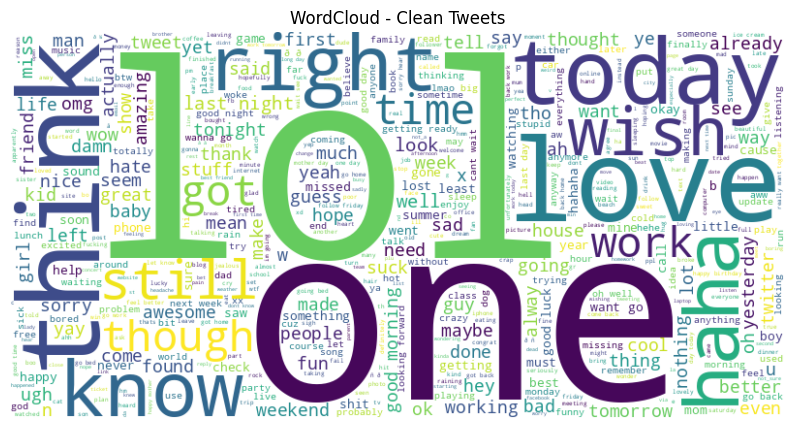

✅ WordCloud kaydedildi: wordcloud_clean.png


In [15]:
plot_wordcloud(df["clean_text"], max_words=500, title="WordCloud - Clean Tweets", save_path="wordcloud_clean.png")


### 🔹 Naive Bayes Model:


### 🔹 Train–Test Split

Here, my **dependent variable** is `label`, and my **independent variable** is `clean_text`.

I split the dataset into **80% training** and **20% testing** subsets.

This ensures that the model **learns only from the training data** and is **validated on unseen test data**, allowing me to evaluate its real-world performance.



In [15]:
from sklearn.model_selection import train_test_split

X = df["clean_text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [16]:
X.head()

0       that's bummer shoulda got david carr third day
1    upset can't update facebook texting might cry ...
2      dived many time ball managed save rest go bound
3                      whole body feel itchy like fire
4                           not_behaving mad can't see
Name: clean_text, dtype: object

### 🔹 Removal of Rare Words:

With the `get_rare_words` function, I identify words in the dataset that occur less than a specified frequency.

In this case, I detect words that appear **fewer than 2 times** and store them in `rare_words`.

I apply this step **only on the training data** to prevent **data leakage**.

Then, using the `remove_rare_words` function, I remove these words from both the training and test sets — since rare words often represent **noise, typos, or overly specific terms** that can reduce the model’s ability to generalize.


In [17]:
from collections import Counter

def get_rare_words(corpus, min_freq=2):
    all_words = " ".join(corpus).split()
    word_freq = Counter(all_words)
    rare_words = {w for w, c in word_freq.items() if c < min_freq}
    print(f"{len(rare_words)} rare words found (freq < {min_freq})")
    return rare_words


In [18]:
rare_words = get_rare_words(X_train, min_freq=2)


152940 rare words found (freq < 2)


In [20]:
def remove_rare_words(corpus, rare_words):
   
    cleaned_corpus = corpus.apply(
        lambda x: " ".join([w for w in x.split() if w not in rare_words])
    )
    return cleaned_corpus


In [21]:
X_train = remove_rare_words(X_train, rare_words)
X_test  = remove_rare_words(X_test, rare_words)


In [22]:
print("Örnek train satırı:", X_train.iloc[0][:200])
print("Örnek test satırı:", X_test.iloc[0][:200])


Örnek train satırı: lol get idea far advance not_even june yet need third knitter summer group
Örnek test satırı: yes black red fav color really wanted color def look awesome jared


xgboost

In [25]:
# =========================================
# 🚀 OPTIMIZED TF-IDF + XGBOOST (NİHAİ DÜZELTME)
# Early Stopping için Veri Ön İşleme (Fit Öncesi)
# =========================================

# ... (Tüm import'lar yerinde kalsın) ...
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import time

# -----------------------------
# 1️⃣ HIZLI TUNING İÇİN KÜÇÜK ÖRNEKLEM (%5-10)
# -----------------------------
print("📊 Veri seti hazırlanıyor...")
start_time = time.time()

sample_size = 0.05 
X_tune_raw, X_temp, y_tune, y_temp = train_test_split(
    X_train, y_train, 
    test_size=1-sample_size, 
    random_state=42, 
    stratify=y_train
)

# Tuning için Eğitim/Validasyon setleri
X_tune_raw, X_val_raw, y_tune, y_val = train_test_split(
    X_tune_raw, y_tune, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_tune
)

print(f"🎯 Tuning için Eğitim Verisi (Ham): {len(X_tune_raw):,} örnek")
print(f"🎯 Tuning için Validasyon Verisi (Ham): {len(X_val_raw):,} örnek")


# -----------------------------
# 2️⃣ HATA DÜZELTMESİ: EVAL_SET İÇİN VERİ ÖN İŞLEME
# RandomizedSearchCV başlamadan önce TF-IDF matrisini oluşturuyoruz
# -----------------------------

# Vektörleştiriciyi eğitim verisi üzerinde eğitiyoruz (Bu, Tuning'in 1. adımıdır)
vectorizer = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1, 1),
    min_df=5,
    max_df=0.9,
    sublinear_tf=True,
    stop_words='english',
)

X_tune = vectorizer.fit_transform(X_tune_raw)
# Sadece transform ediyoruz, yeni feature öğrenmiyoruz.
X_val = vectorizer.transform(X_val_raw)

# EVAL_SET'i nümerik (sayısal) matrislerle hazırlıyoruz
eval_set_numeric = [(X_val, y_val)]
print("✅ Eval Set (Sayısal Matris) hazır.")

# -----------------------------
# 3️⃣ SADECE XGBOOST İÇİN PIPELINE TANIMI
# Vektörleştirme manuel yapıldığı için Pipeline'dan çıkarıldı!
# -----------------------------
pipe_xgb_only = XGBClassifier(
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=5,
    tree_method='hist'
)

# 4️⃣ SADECE XGBOOST PARAMETRELERİ
# max_features artık RandomizedSearch'te aranmayacak.
param_dist_xgb_only = {
    "n_estimators": [100, 150],
    "max_depth": [4, 6],
    "learning_rate": [0.1, 0.15],
    "subsample": [0.8]
}

# -----------------------------
# 5️⃣ HIZLI RANDOMIZEDSEARCH (4 iter, cv=2)
# -----------------------------
print("🔍 Hızlı hyperparameter tuning başlıyor (Sadece XGBoost parametreleri)...")

rand_xgb = RandomizedSearchCV(
    estimator=pipe_xgb_only,
    param_distributions=param_dist_xgb_only,
    n_iter=4,
    scoring="accuracy",
    cv=2,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Düzeltme: fit() şimdi sayısal veriyi ve XGBoost'un beklediği eval_set'i alıyor.
rand_xgb.fit(
    X_tune, y_tune,
    eval_set=eval_set_numeric, # Doğrudan eval_set olarak gönderiliyor
    verbose=False
)

tuning_time = time.time() - start_time
print(f"⏱️ Tuning süresi: {tuning_time:.2f} saniye")

print("\n✅ En iyi parametreler:")
print(rand_xgb.best_params_)

# -----------------------------
# 6️⃣ TÜM VERİDE EĞİTİM (FINAL MODEL)
# -----------------------------
print("\n🎯 Final model tüm veri ile eğitiliyor...")

# En iyi parametreleri alıyoruz
final_params = rand_xgb.best_params_

# Tüm veriyi (1.6M) final TF-IDF matrisine dönüştürüyoruz
final_vectorizer = TfidfVectorizer(
    max_features=8000, # Vektörleyici ayarı sabitlendi (veya 5000)
    ngram_range=(1, 1),
    min_df=5,
    max_df=0.9,
    sublinear_tf=True,
    stop_words='english',
)
X_train_final = final_vectorizer.fit_transform(X_train)
X_test_final = final_vectorizer.transform(X_test)
print(f"✅ Final TF-IDF Matrisi hazır. Boyut: {X_train_final.shape}")


# Final XGBoost modelini eğitiyoruz
final_xgb = XGBClassifier(
    **final_params, # En iyi parametreler
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,
    tree_method='hist'
)

# Modeli tüm veri üzerinde eğitiyoruz (bu adım en uzun sürecektir)
final_xgb.fit(X_train_final, y_train)


# -----------------------------
# 7️⃣ TEST DEĞERLENDİRMESİ
# -----------------------------
print("\n📊 Test seti değerlendiriliyor...")
y_pred = final_xgb.predict(X_test_final)
y_proba = final_xgb.predict_proba(X_test_final)[:, 1]

print("\n🎯 Test Accuracy:", accuracy_score(y_test, y_pred))
print("📋 Classification Report:")
print(classification_report(y_test, y_pred))

# ... (Görselleştirmeler aynı şekilde final_xgb ve X_test_final kullanarak devam eder) ...

total_time = time.time() - start_time
print(f"\n✅ Tüm işlem tamamlandı! Toplam süre: {total_time:.2f} saniye")

📊 Veri seti hazırlanıyor...
🎯 Tuning için Eğitim Verisi (Ham): 51,200 örnek
🎯 Tuning için Validasyon Verisi (Ham): 12,800 örnek
✅ Eval Set (Sayısal Matris) hazır.
🔍 Hızlı hyperparameter tuning başlıyor (Sadece XGBoost parametreleri)...
Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] END vectorizer__max_features=5000, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.6s
[CV] END vectorizer__max_features=8000, xgb__learning_rate=0.15, xgb__max_depth=6, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.15, max_depth=4, n_estimators=150, subsample=0.8; total time= 9.8min
[CV] END learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.8; total time= 6.5min
[CV] END vectorizer__max_features=5000, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.6s
[CV] END vectorizer__max_features=5000, xgb__learning_rate=0.15, xgb__max_depth=4, xg

--- Final Model Test Metrics ---
🎯 Test Accuracy: 0.7228

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.60      0.68    160000
           1       0.68      0.85      0.75    160000

    accuracy                           0.72    320000
   macro avg       0.74      0.72      0.72    320000
weighted avg       0.74      0.72      0.72    320000



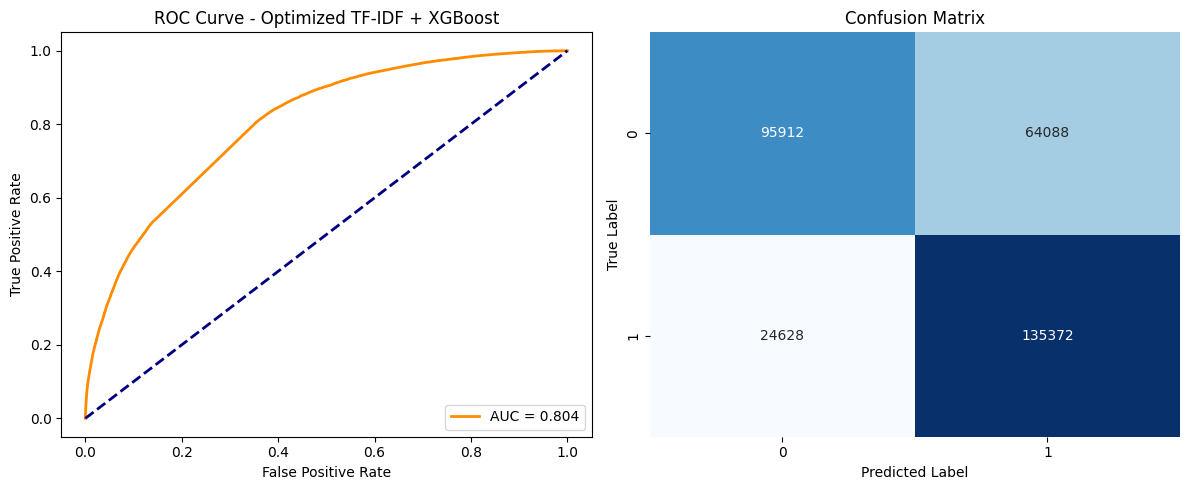


✅ Final AUC Score: 0.8039


In [27]:
# =========================================
# 7️⃣ VISUALIZATIONS AND FINAL METRICS
# =========================================
from sklearn.metrics import (
    accuracy_score, classification_report, ConfusionMatrixDisplay,
    roc_curve, auc, confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Note: This cell requires y_test, y_pred, and y_proba variables 
# to have been calculated in the preceding code block.

# -----------------------------
# Print Core Metrics
# -----------------------------
print("--- Final Model Test Metrics ---")
print(f"🎯 Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred))


# -----------------------------
# Calculate ROC Curve and AUC
# -----------------------------
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 5))

# 1. ROC Curve Plot
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Optimized TF-IDF + XGBoost")
plt.legend(loc="lower right")

# -----------------------------
# Confusion Matrix Plot
# -----------------------------
# 2. Confusion Matrix
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=np.unique(y_test), # Predicted labels
    yticklabels=np.unique(y_test)  # True labels
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.tight_layout()
plt.show()

print(f"\n✅ Final AUC Score: {roc_auc:.4f}")

### 🔹 Naive Bayes Model – Count vs TF-IDF:

For the Naive Bayes model, I test two different feature extraction methods (vectorizers):

* **CountVectorizer:** Counts how many times each word appears.
* **TF-IDF:** Evaluates the importance of words by down-weighting common but less informative ones.

I compare both models based on **Accuracy, Precision, Recall,** and **F1-score**.
The vectorizer with the **best overall performance** is selected for the next stage.



=== Count + Naive Bayes ===
Accuracy: 0.7738
              precision    recall  f1-score   support

           0       0.77      0.78      0.78    160000
           1       0.78      0.77      0.77    160000

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



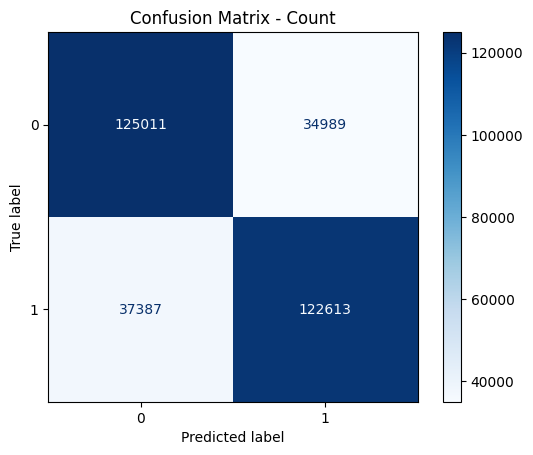


=== TF-IDF + Naive Bayes ===
Accuracy: 0.7680
              precision    recall  f1-score   support

           0       0.76      0.77      0.77    160000
           1       0.77      0.76      0.77    160000

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



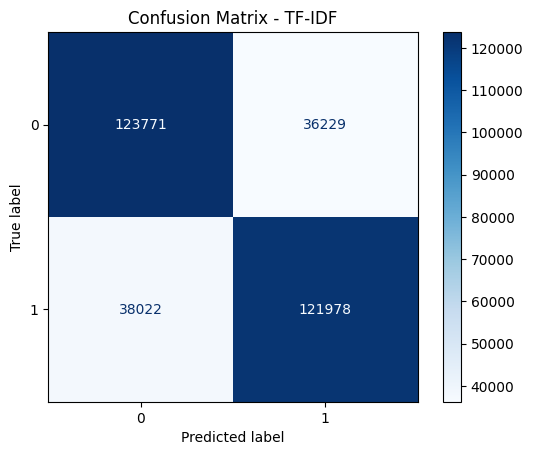


>>> En iyi vectorizer: Count (Accuracy = 0.7738)


In [28]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Dictionary 
results = {}

for vect_name, vect in [("Count", CountVectorizer()), ("TF-IDF", TfidfVectorizer())]:
    pipe = Pipeline([
        ("vectorizer", vect),
        ("nb", MultinomialNB())
    ])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    results[vect_name] = (pipe, acc, y_pred)
    
    print(f"\n=== {vect_name} + Naive Bayes ===")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    
    ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, cmap="Blues")
    plt.title(f"Confusion Matrix - {vect_name}")
    plt.show()

# Select the best one
best_vect_name = max(results, key=lambda k: results[k][1])
print(f"\n>>> En iyi vectorizer: {best_vect_name} (Accuracy = {results[best_vect_name][1]:.4f})")


### 🔹 Hyperparameter Tuning (Randomized Search CV)

**Purpose:** To find the optimal parameters for the Naive Bayes model.
The parameters explored include:

* `alpha`: Laplace smoothing factor
* `fit_prior`: whether to use class prior probabilities
* `ngram_range`, `min_df`, `max_df`: vectorizer parameters

Using **RandomizedSearchCV**, multiple parameter combinations are tested with **3-fold cross-validation** to identify the best-performing configuration.


In [29]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np


chosen_vect = CountVectorizer() if best_vect_name == "Count" else TfidfVectorizer()

pipe = Pipeline([
    ("vectorizer", chosen_vect),
    ("nb", MultinomialNB())
])

param_dist = {
    "vectorizer__ngram_range": [(1,1), (1,2)],
    "vectorizer__min_df": [1, 2, 5],
    "vectorizer__max_df": [0.9, 0.95, 1.0],
    "nb__alpha": np.logspace(-2, 2, 30),  # 0.01 → 100
    "nb__fit_prior": [True, False]
}

rand_search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=25,
    scoring="accuracy",
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

rand_search.fit(X_train, y_train)

print("\n=== Fine Tuning Results ===")
print("Best Params:", rand_search.best_params_)
print(f"Best CV Score: {rand_search.best_score_:.4f}")


Fitting 3 folds for each of 25 candidates, totalling 75 fits

=== Fine Tuning Results ===
Best Params: {'vectorizer__ngram_range': (1, 2), 'vectorizer__min_df': 5, 'vectorizer__max_df': 0.95, 'nb__fit_prior': True, 'nb__alpha': 5.736152510448681}
Best CV Score: 0.7811


### 🔹 Model Performance Evaluation

After selecting the best model, I evaluate its performance on the test set using the following metrics:

* **Accuracy, Precision, Recall, and F1-score**
* **Confusion Matrix** – to visualize classification errors
* **ROC Curve** – to analyze True/False Positive rates and compute the **AUC score**

These metrics help me understand **how accurately the model distinguishes between sentiment classes**.



=== Test Set Performance ===
Accuracy: 0.784153125
              precision    recall  f1-score   support

           0       0.78      0.79      0.79    160000
           1       0.79      0.78      0.78    160000

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



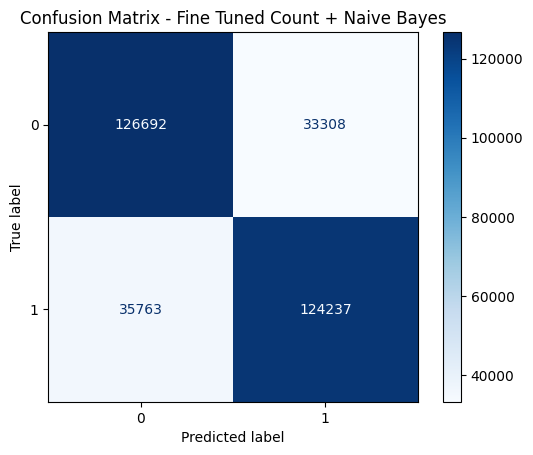

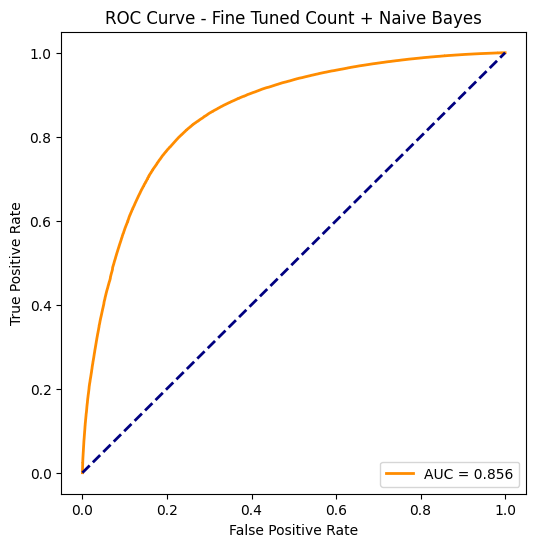

In [30]:
from sklearn.metrics import roc_curve, auc


best_model = rand_search.best_estimator_
y_pred_best = best_model.predict(X_test)
y_proba_best = best_model.predict_proba(X_test)[:, 1]

print("\n=== Test Set Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap="Blues")
plt.title(f"Confusion Matrix - Fine Tuned {best_vect_name} + Naive Bayes")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_best)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve - Fine Tuned {best_vect_name} + Naive Bayes")
plt.legend(loc="lower right")
plt.show()



=== Classification Report ===


,precision,recall,f1-score,support
0,0.780,0.792,0.786,160000.000000
1,0.789,0.776,0.782,160000.000000
accuracy,0.784,0.784,0.784,0.784153
macro avg,0.784,0.784,0.784,320000.000000
weighted avg,0.784,0.784,0.784,320000.000000



=== Confusion Matrix (Numeric) ===
[[126692  33308]
 [ 35763 124237]]


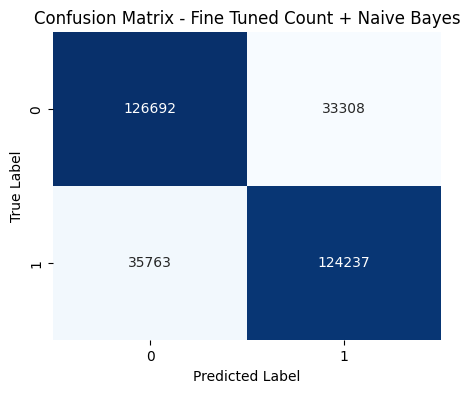

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


print("\n=== Classification Report ===")
report_dict = classification_report(y_test, y_pred_best, output_dict=True)
report_df = pd.DataFrame(report_dict).T


display(report_df.style.background_gradient(cmap="YlGnBu").format({"precision":"{:.3f}", "recall":"{:.3f}", "f1-score":"{:.3f}"}))


cm = confusion_matrix(y_test, y_pred_best)
print("\n=== Confusion Matrix (Numeric) ===")
print(cm)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title(f"Confusion Matrix - Fine Tuned {best_vect_name} + Naive Bayes")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


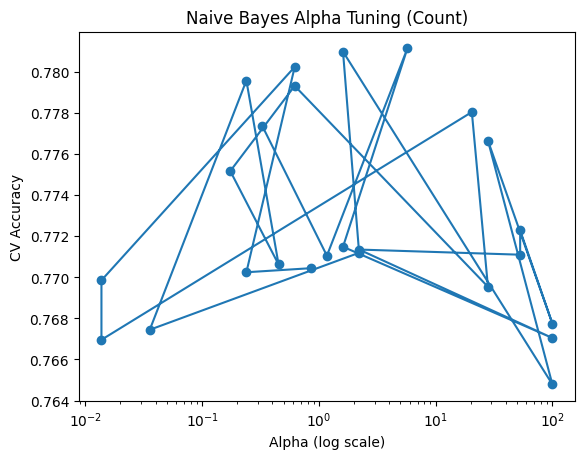

In [32]:
results_df = pd.DataFrame(rand_search.cv_results_)
plt.semilogx(results_df["param_nb__alpha"], results_df["mean_test_score"], "o-")
plt.xlabel("Alpha (log scale)")
plt.ylabel("CV Accuracy")
plt.title(f"Naive Bayes Alpha Tuning ({best_vect_name})")
plt.show()


### Logistic regression model:


###  Logistic Regression Model Training

In this cell, I built two Logistic Regression models using **CountVectorizer** and **TF-IDF Vectorizer**.  
For each model, I calculated the **accuracy score**, printed the **classification report**, and visualized the **confusion matrix**.  
Finally, I displayed which vectorizer achieved the **highest accuracy score**.



=== Count + Logistic Regression ===
Accuracy: 0.7840
              precision    recall  f1-score   support

           0       0.80      0.76      0.78    160000
           1       0.77      0.81      0.79    160000

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



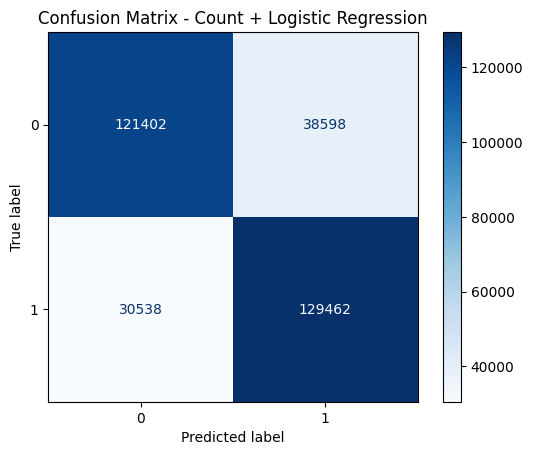


=== TF-IDF + Logistic Regression ===
Accuracy: 0.7856
              precision    recall  f1-score   support

           0       0.80      0.77      0.78    160000
           1       0.78      0.80      0.79    160000

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



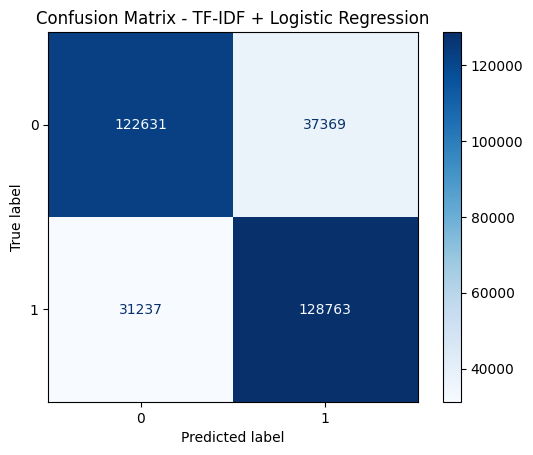


>>> En iyi vectorizer: TF-IDF (Accuracy = 0.7856)


In [33]:
results_lr = {}

for vect_name, vect in [("Count", CountVectorizer()), ("TF-IDF", TfidfVectorizer())]:
    pipe = Pipeline([
        ("vectorizer", vect),
        ("lr", LogisticRegression(max_iter=200, solver="liblinear"))
    ])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    results_lr[vect_name] = (pipe, acc, y_pred)
    
    print(f"\n=== {vect_name} + Logistic Regression ===")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    
    ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, cmap="Blues")
    plt.title(f"Confusion Matrix - {vect_name} + Logistic Regression")
    plt.show()

best_vect_name_lr = max(results_lr, key=lambda k: results_lr[k][1])
print(f"\n>>> En iyi vectorizer: {best_vect_name_lr} (Accuracy = {results_lr[best_vect_name_lr][1]:.4f})")


### Hyperparameter Tuning for Logistic Regression (Grid Search)

In this step, I selected the **best-performing vectorizer** from the previous experiment and rebuilt the Logistic Regression model.  
Then, I performed **GridSearchCV** to tune hyperparameters such as `C`, `penalty`, `ngram_range`, and `min_df`.  
The goal was to find the **optimal parameter combination** that yields the highest accuracy.  
Finally, I printed the best parameters (`best_params_`) and the highest cross-validation score (`best_score_`).


In [34]:
# Vectorizer seçimi
chosen_vect = CountVectorizer() if best_vect_name_lr == "Count" else TfidfVectorizer()

pipe_lr = Pipeline([
    ("vectorizer", chosen_vect),
    ("lr", LogisticRegression(solver="liblinear", max_iter=300))
])

param_grid_lr = {
    "vectorizer__ngram_range": [(1,1), (1,2)],
    "vectorizer__min_df": [1, 3, 5],
    "lr__C": [0.01, 0.1, 1, 10],
    "lr__penalty": ["l1", "l2"]
}

grid_lr = GridSearchCV(
    pipe_lr,
    param_grid=param_grid_lr,
    cv=3,
    scoring="accuracy",
    verbose=2,
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)

print("\n=== Logistic Regression Grid Search Results ===")
print("Best Params:", grid_lr.best_params_)
print(f"Best CV Score: {grid_lr.best_score_:.4f}")


Fitting 3 folds for each of 48 candidates, totalling 144 fits

=== Logistic Regression Grid Search Results ===
Best Params: {'lr__C': 1, 'lr__penalty': 'l2', 'vectorizer__min_df': 3, 'vectorizer__ngram_range': (1, 2)}
Best CV Score: 0.7967


###  Evaluating the Best Logistic Regression Model on the Test Set

Here, I tested the **best Logistic Regression model** obtained from Grid Search on the test dataset.  
I displayed the model’s **accuracy**, **precision**, **recall**, and **F1-score** using a classification report.  
Additionally, I visualized the **confusion matrix** to observe the model’s performance in distinguishing classes.  
This helped assess how much the hyperparameter tuning improved the model.



=== Logistic Regression Test Performance ===
Accuracy: 0.80055
              precision    recall  f1-score   support

           0       0.81      0.78      0.80    160000
           1       0.79      0.82      0.80    160000

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



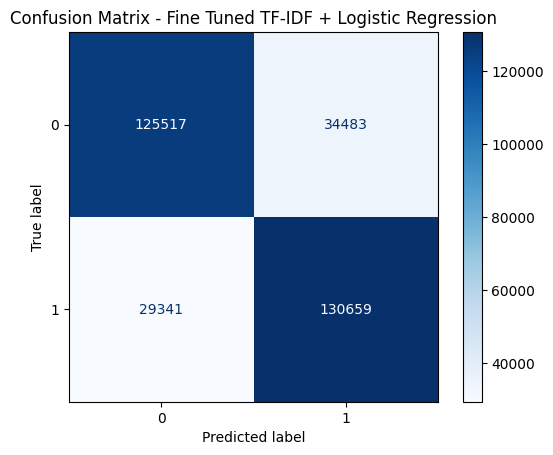

In [35]:
best_lr_model = grid_lr.best_estimator_
y_pred_lr = best_lr_model.predict(X_test)
y_proba_lr = best_lr_model.predict_proba(X_test)[:, 1]

print("\n=== Logistic Regression Test Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_lr_model, X_test, y_test, cmap="Blues")
plt.title(f"Confusion Matrix - Fine Tuned {best_vect_name_lr} + Logistic Regression")
plt.show()


###  Analyzing Model Discrimination Power with the ROC Curve

In this cell, I plotted the **ROC curve** for the best Logistic Regression model.  
The ROC curve shows how well the model separates positive and negative classes.  
I also calculated the **AUC (Area Under the Curve)** score as a quantitative measure of overall performance.  
The closer the AUC is to 1, the better the model distinguishes between the two classes.


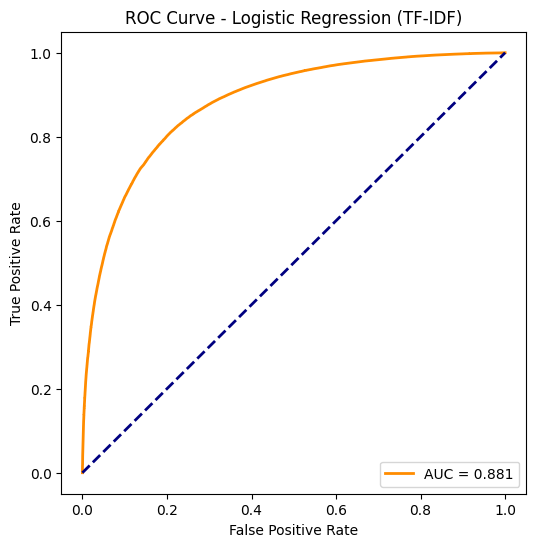

In [36]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba_lr)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve - Logistic Regression ({best_vect_name_lr})")
plt.legend(loc="lower right")
plt.show()


###  Comprehensive Model Comparison

In this cell, I used a custom-built **ModelComparison** class to compare the performance of all models (e.g., **Naive Bayes** and **Logistic Regression**).  
For each model, I computed the following metrics:  
- **Accuracy**  
- **Precision**  
- **Recall**  
- **F1-Score**  
- **AUC (Area Under Curve)**  

Additionally, I performed the following steps:  
- Created a **comparison table** summarizing all metrics.  
- Displayed **confusion matrices** for each model side by side.  
- Compared **ROC curves** of all models in a single plot.  
- Generated **model rankings** based on each metric and a final **executive summary**.  

This comprehensive comparison helped identify the **best-performing model** overall.


🚀 Starting comprehensive model comparison...
📊 Adding model results...
✅ XGBoost sonuçları başarıyla eklendi.

📊 Creating comparison table...
                             accuracy  precision  recall     f1    auc
XGBoost (Optimized TF-IDF)      0.723      0.679   0.846  0.753  0.804
Naive Bayes (Tuned)             0.784      0.789   0.776  0.782  0.856
Logistic Regression (Tuned)     0.801      0.791   0.817  0.804  0.881
NB + Count (Baseline)           0.774      0.778   0.766  0.772  0.847
NB + TF-IDF (Baseline)          0.768      0.771   0.762  0.767  0.850
LR + Count (Baseline)           0.784      0.770   0.809  0.789  0.858
LR + TF-IDF (Baseline)          0.786      0.775   0.805  0.790  0.866

📈 Generating visualizations...


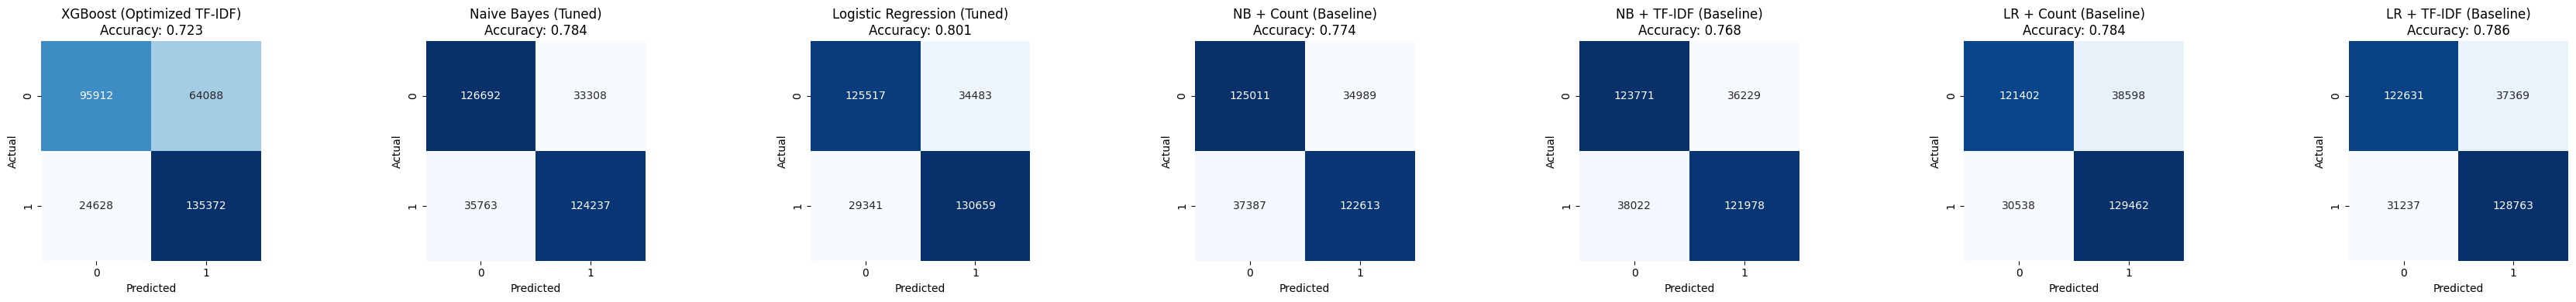

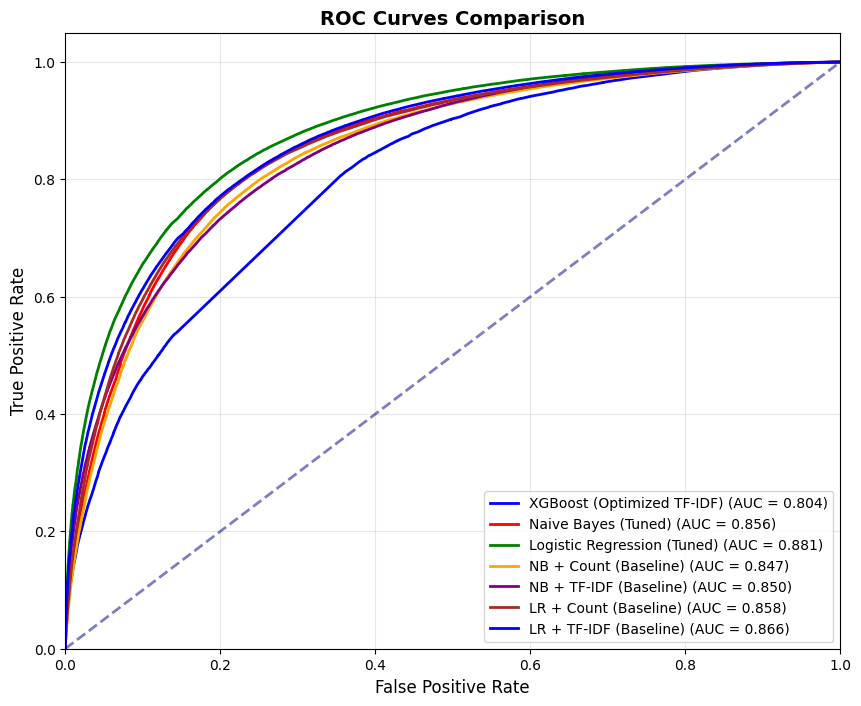


🏆 MODEL RANKING
🥇 OVERALL RANKING (by F1-Score):
1. Logistic Regression (Tuned) F1: 0.804
2. LR + TF-IDF (Baseline)    F1: 0.790
3. LR + Count (Baseline)     F1: 0.789
4. Naive Bayes (Tuned)       F1: 0.782
5. NB + Count (Baseline)     F1: 0.772
6. NB + TF-IDF (Baseline)    F1: 0.767
7. XGBoost (Optimized TF-IDF) F1: 0.753

📊 DETAILED RANKINGS:

ACCURACY Rankings:
  1. Logistic Regression (Tuned) 0.801
  2. LR + TF-IDF (Baseline) 0.786
  3. Naive Bayes (Tuned)  0.784
  4. LR + Count (Baseline) 0.784
  5. NB + Count (Baseline) 0.774
  6. NB + TF-IDF (Baseline) 0.768
  7. XGBoost (Optimized TF-IDF) 0.723

PRECISION Rankings:
  1. Logistic Regression (Tuned) 0.791
  2. Naive Bayes (Tuned)  0.789
  3. NB + Count (Baseline) 0.778
  4. LR + TF-IDF (Baseline) 0.775
  5. NB + TF-IDF (Baseline) 0.771
  6. LR + Count (Baseline) 0.770
  7. XGBoost (Optimized TF-IDF) 0.679

RECALL Rankings:
  1. XGBoost (Optimized TF-IDF) 0.846
  2. Logistic Regression (Tuned) 0.817
  3. LR + Count (Baseline) 0.8

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

class ModelComparison:
    """Kapsamlı model karşılaştırma sınıfı"""
    
    def __init__(self):
        self.results = {}
        self.comparison_df = None
    
    def add_model_results(self, model_name, y_true, y_pred, y_proba, model_object=None):
        """Model sonuçlarını ekle"""
        self.results[model_name] = {
            'y_true': y_true,
            'y_pred': y_pred, 
            'y_proba': y_proba,
            'model': model_object,
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred),
            'recall': recall_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred),
            'auc': roc_auc_score(y_true, y_proba)
        }
    
    def create_comparison_table(self):
        """Karşılaştırma tablosu oluştur"""
        metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
        
        comparison_data = {}
        for metric in metrics:
            comparison_data[metric] = [self.results[model][metric] for model in self.results.keys()]
        
        self.comparison_df = pd.DataFrame(comparison_data, index=list(self.results.keys()))
        return self.comparison_df
    
    
    
    def plot_confusion_matrices(self):
        """Confusion matrix'leri karşılaştır"""
        n_models = len(self.results)
        fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))
        
        if n_models == 1:
            axes = [axes]
        
        for i, (model_name, result) in enumerate(self.results.items()):
            cm = confusion_matrix(result['y_true'], result['y_pred'])
            
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                       ax=axes[i], cbar=False, square=True)
            axes[i].set_title(f'{model_name}\nAccuracy: {result["accuracy"]:.3f}')
            axes[i].set_xlabel('Predicted')
            axes[i].set_ylabel('Actual')
        
        plt.tight_layout()
        plt.show()
    
    def plot_roc_curves(self):
        """ROC eğrilerini karşılaştır"""
        plt.figure(figsize=(10, 8))
        
        colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
        
        for i, (model_name, result) in enumerate(self.results.items()):
            fpr, tpr, _ = roc_curve(result['y_true'], result['y_proba'])
            auc_score = result['auc']
            
            plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2, 
                    label=f'{model_name} (AUC = {auc_score:.3f})')
        
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('ROC Curves Comparison', fontsize=14, fontweight='bold')
        plt.legend(loc="lower right", fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.show()
    
    def detailed_classification_reports(self):
        """Detaylı classification report'lar"""
        for model_name, result in self.results.items():
            print(f"\n{'='*60}")
            print(f"📊 DETAILED CLASSIFICATION REPORT - {model_name.upper()}")
           
    
    def model_ranking(self):
        """Model sıralaması"""
        print(f"\n🏆 MODEL RANKING")
        print("="*50)
        
        # Her metrik için ranking
        metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
        rankings = {}
        
        for metric in metrics:
            sorted_models = sorted(self.results.items(), 
                                 key=lambda x: x[1][metric], reverse=True)
            rankings[metric] = [(model, score[metric]) for model, score in sorted_models]
        
        # Overall ranking (F1 score'a göre)
        overall_ranking = sorted(self.results.items(), 
                               key=lambda x: x[1]['f1'], reverse=True)
        
        print("🥇 OVERALL RANKING (by F1-Score):")
        for i, (model, scores) in enumerate(overall_ranking, 1):
            print(f"{i}. {model:<25} F1: {scores['f1']:.3f}")
        
        print("\n📊 DETAILED RANKINGS:")
        for metric in metrics:
            print(f"\n{metric.upper()} Rankings:")
            for i, (model, score) in enumerate(rankings[metric], 1):
                print(f"  {i}. {model:<20} {score:.3f}")
    
    def generate_summary_report(self):
        """Özet rapor"""
        print(f"\n📋 EXECUTIVE SUMMARY")
        print("="*60)
        
        best_overall = max(self.results.items(), key=lambda x: x[1]['f1'])
        best_accuracy = max(self.results.items(), key=lambda x: x[1]['accuracy'])
        best_auc = max(self.results.items(), key=lambda x: x[1]['auc'])
        
        print(f"🎯 BEST OVERALL MODEL: {best_overall[0]}")
        print(f"   F1-Score: {best_overall[1]['f1']:.3f}")
        print(f"   Accuracy: {best_overall[1]['accuracy']:.3f}")
        print(f"   AUC: {best_overall[1]['auc']:.3f}")
        
        print(f"\n🎯 BEST ACCURACY: {best_accuracy[0]} ({best_accuracy[1]['accuracy']:.3f})")
        print(f"🎯 BEST AUC: {best_auc[0]} ({best_auc[1]['auc']:.3f})")
        
    #

# KULLANIM KODU
def compare_all_models():
    """Tüm modelleri karşılaştır"""

    # Model comparison object'i oluştur
    comparator = ModelComparison()

    # Model sonuçlarını ekle
    print("📊 Adding model results...")

    # =========================================================
    # 🎯 XGBOOST MODEL SONUÇLARINI EKLEME (YENİ KISIM)
    # =========================================================
    try:
        # Final XGBoost modelini kullanarak tahminleri hesapla
        # Bu kısım, y_test, final_xgb ve X_test_final değişkenlerinin global olarak
        # tanımlı olduğunu varsayar.
        y_pred_xgb = final_xgb.predict(X_test_final)
        y_proba_xgb = final_xgb.predict_proba(X_test_final)[:, 1]

        comparator.add_model_results(
            "XGBoost (Optimized TF-IDF)",
            y_test,
            y_pred_xgb,
            y_proba_xgb,
            final_xgb
        )
        print("✅ XGBoost sonuçları başarıyla eklendi.")
    except NameError as e:
        print(f"⚠️ XGBoost model sonuçları eklenemedi: {e}")
        print("Lütfen 'final_xgb', 'X_test_final' veya 'y_test' değişkenlerinin tanımlı olduğundan emin olun.")
    # =========================================================
    # 🎯 XGBOOST MODEL SONUÇLARINI EKLEME SONU
    # =========================================================


    # Naive Bayes Results (Mevcut koddan)
    if 'y_pred_best' in globals():
        comparator.add_model_results(
            "Naive Bayes (Tuned)",
            y_test,
            y_pred_best,
            y_proba_best,
            best_model
        )

    # Logistic Regression Results (Mevcut koddan)
    if 'y_pred_lr' in globals():
        comparator.add_model_results(
            "Logistic Regression (Tuned)",
            y_test,
            y_pred_lr,
            y_proba_lr,
            best_lr_model
        )

    # Eğer baseline results varsa onları da ekle (Mevcut koddan)
    if 'results' in globals():
        for vect_name, (pipe, acc, y_pred) in results.items():
            y_proba = pipe.predict_proba(X_test)[:, 1]
            comparator.add_model_results(
                f"NB + {vect_name} (Baseline)",
                y_test,
                y_pred,
                y_proba,
                pipe
            )

    if 'results_lr' in globals():
        for vect_name, (pipe, acc, y_pred) in results_lr.items():
            y_proba = pipe.predict_proba(X_test)[:, 1]
            comparator.add_model_results(
                f"LR + {vect_name} (Baseline)",
                y_test,
                y_pred,
                y_proba,
                pipe
            )

    # Karşılaştırma tablosu
    print("\n📊 Creating comparison table...")
    comparison_table = comparator.create_comparison_table()
    print(comparison_table.round(3))

    # Görselleştirmeler
    print("\n📈 Generating visualizations...")

    comparator.plot_confusion_matrices()
    comparator.plot_roc_curves()

    # Detaylı raporlar
    # comparator.detailed_classification_reports() # Çok fazla çıktı verebilir, devre dışı bıraktık

    comparator.model_ranking()
    comparator.generate_summary_report()

    return comparator

# Karşılaştırmayı çalıştır
print("🚀 Starting comprehensive model comparison...")
model_comparator = compare_all_models()